In [1]:
import numpy as np
import pandas as pd
import os
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import cv2
from torch.autograd import Variable
from torch.utils.data import DataLoader,random_split,Dataset,RandomSampler
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

In [2]:
data="../Scripts/image leaf/data/train/"


In [3]:
img_transform=transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

datasets=ImageFolder(root=data,transform=img_transform)

In [4]:
print("Length Of The Images ",len(datasets))

Length Of The Images  1951


In [5]:
train_size=int(len(datasets)*0.7)
test_size=int(len(datasets)-train_size)
train_size,test_size

(1365, 586)

In [6]:
train_data,valid_data=random_split(datasets,[train_size,test_size])

In [7]:
train_loader=DataLoader(train_data,batch_size=64,shuffle=True,num_workers=0)
valid_loader=DataLoader(valid_data,batch_size=64,shuffle=False,num_workers=0)

In [8]:
i,j=next(iter(train_loader))
print(i.shape)

torch.Size([64, 3, 224, 224])


In [9]:
len(datasets.class_to_idx)

4

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn1=nn.Conv2d(3,12,5)
        self.max1=nn.MaxPool2d(2,2)
        self.cnn2=nn.Conv2d(12,32,5)
        self.fc1=nn.Linear(32*53*53,64)
        self.fc2=nn.Linear(64,len(datasets.class_to_idx))
        
    def forward(self,x):
        x=self.max1(F.relu(self.cnn1(x)))
        x=self.max1(F.relu(self.cnn2(x)))
        x=x.view(-1,32*53*53)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

In [11]:
model=CNN()
model

CNN(
  (cnn1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=89888, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [14]:
optimizer=optim.Adam(model.parameters(),lr=0.01)
criterion=nn.CrossEntropyLoss()

In [15]:
device=("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
num_epochs=2
for epoch in tqdm.tqdm(range(num_epochs)):
    correct = 0
    for idx,(data,target) in enumerate(train_loader):
#         data=Variable(data.float()).to(device)
#         labels=Variable(target).to(device)
        output=model(data)
        loss=criterion(output,target)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
#         correct += (output == labels).float().sum()
#         output = (output>0.5).float()
#         correct = (output == labels).float().sum()
        _,preds=torch.max(data,dim=1)
        correct=torch.tensor(torch.sum(preds==target).item() / len(target))
    print("Epoch {}/{}, Loss: {:.3f}, Accuracy".format(epoch+1,num_epochs, loss.data,correct))
#     print(loss.data)
        
        
        

  0%|                                                                                            | 0/2 [01:08<?, ?it/s]


RuntimeError: The size of tensor a (224) must match the size of tensor b (64) at non-singleton dimension 2

In [27]:
trainloader=train_loader
testloader=valid_loader
test_loader=valid_loader

In [28]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')

Epoch 1/1.. Train loss: 1.224.. Test loss: 1.207.. Test accuracy: 0.523
Epoch 1/1.. Train loss: 1.260.. Test loss: 1.194.. Test accuracy: 0.477


c:\users\parikalp\appdata\local\programs\python\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [30]:
import matplotlib.pyplot as plt

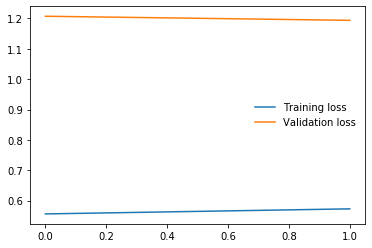

In [31]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [51]:
data_dir="../Scripts/image leaf/data/test_img/"
test_transforms=transforms.Compose([transforms.Resize(224),transforms.ToTensor()])

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('aerialmodel.pth')
model.eval()

CNN(
  (cnn1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=89888, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [53]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [54]:
def get_random_images(num):
    data = ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [55]:
data = ImageFolder(data_dir, transform=test_transforms)
classes = data.classes

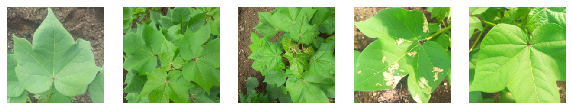

In [57]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
#     sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()